# Modeling
Data is separated on a candidate-basis to observe polls prior to and before a candidate suspends their campaign.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import numpy as np
import pandas as pd
import os
import math

import stats

## Read File Written in 02-DataCleaning

In [2]:
candidates = pd.read_csv('candidates.csv', index_col='name')

## Read File Written in 03-Modeling

In [3]:
polls = pd.read_csv('bootPolls.csv')

Convert date from string to datetime.

In [4]:
polls.date = pd.Series(pd.DatetimeIndex(polls.date))
polls.index = polls.date
del polls['date']

candidates.date = pd.to_datetime(candidates.date)

stats.Equals100(polls)

## Data Modeling Functions Defintions

### Before Campaign Suspension

Function to get average polling for a single active candidate before a candidate drops out.

In [5]:
def getBeforeAverage(pollGroup, dropout, cand):
    """Returns average polling for a single candidate in the week prior to another candidate dropping out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    cand : str
        The name of the candidate whose average polling is being calculated.
    """
    
    tot = 0                             # used to as numerator in calculating the mean
    count = 0                           # regular iterator. Also used to as denominator in calculating the mean
    iterDate = pollGroup.index[count]   # used to check where date is relative to the date of suspension
    
    while candidates['date'][dropout] - iterDate >= datetime.timedelta(days=0):
        tot += pollGroup[cand][count]
        count += 1
        iterDate = pollGroup.index[count]

    return tot/count

Function to create list of average polling for all other candidates before a candidate drops out.

In [6]:
def BeforeAverages(pollGroup, dropout):
    """Returns a list of average polling for all active candidate in the week prior to another
       candidate dropping out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    """
    
    averages = []
    for c in pollGroup.columns:    # for each candidate
        averages.append(getBeforeAverage(pollGroup, dropout, c))
        
    return averages

### After Campaign Suspension

Function to retrieve difference in days since date of suspension/dropout.

In [7]:
def dateDiff(dropout, iterDate):
    """Returns difference in days between date iterator and the date a candidate dropped out of the race.
    
    Parameters
    ----------
    dropout : str
        The name of the candidate that dropped out.
    iterDate : str
        The name of the candidate whose average polling is being calculated.
    """
    return (iterDate - candidates['date'][dropout]).days

Function to get weighted average polling for a single active candidate after a candidate drops out. Weight is determined by days after campaign suspension; the further away from the date of suspension, the more weight the polling data holds.

In [8]:
def getAfterAverage(pollGroup, dropout, cand):
    """Returns average polling for a candidate in the week after another candidate drops out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    cand : str
        The name of the candidate whose average polling is being calculated.
    """
    
    tot = 0                             # used to as numerator in calculating the mean
    count = 0                           # regular iterator
    dateCount = 0                       # used to as denomiator in calculating the mean
    iterDate = pollGroup.index[count]   # used to check where date is relative to the date of suspension
    
    # Get the date iterator to the dropout date
    while candidates['date'][dropout] - iterDate >= datetime.timedelta(days=0):
        count += 1
        iterDate = pollGroup.index[count]
    
    # Iterates through poll grouping conducted in the week after a candidate dropped out of the race
    while count < len(pollGroup.index):
        iterDate = pollGroup.index[count]
        diff = dateDiff(dropout, iterDate)
        candCount = pollGroup[cand][count]
        
        if math.isnan(candCount) == False:    # only uses numbers
            tot += candCount * diff           # gives weight to polls conducted further away from the date of dropping
            dateCount += diff
        count += 1
        
    if dateCount == 0:    # can't divide by zero, so just return 0 if no polls conducted after date of dropping
        return float('nan')
    else:
        return tot/dateCount

Function to get weighted average polling for all other candidtates after a candidate drops out.

In [9]:
def AfterAverages(pollGroup, dropout):
    """Returns a list of average polling for all active candidate in the week after another
       candidate drops out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    """
    
    averages = []
    for c in pollGroup.columns:
        averages.append(getAfterAverage(pollGroup, dropout, c))
    return averages

## Data Modeling Functions Apllications

Create a list of dictionaries holding the name of each candidate that suspended their campaign and the DataFrames of polling data from a week before to a week after that candidate suspended their campaign.

In [11]:
pollList = []

pollIndex = [c for c in candidates.index if candidates.dropped[c] == True]
for p in pollIndex:
    pollList.append({'name': p, 'poll': stats.BiWeekPolling(polls, candidates, p)})

Create a DataFrame indexed by the candidates that dropped out of the race during the primaries. Each column holds other candidates' average polling numbers in the week prior to a candidate's campaign suspension.

Each cell contains the polling for a candidate in the column the week before the candidate in the row dropped out.

In [12]:
WeekBeforeDrop = []

for p in range(len(pollList)):
    WeekBeforeDrop.append(BeforeAverages(pollList[p]['poll'], pollList[p]['name']))
    
PollingBeforeDrop = pd.DataFrame(WeekBeforeDrop, columns=polls.columns, index=pollIndex)
PollingBeforeDrop.index.names = ['name']
stats.Equals100(PollingBeforeDrop)
PollingBeforeDrop

,Trump,Cruz,Rubio,Kasich,Carson,Bush,Christie,Fiorina,Gilmore,Huckabee,Paul,Santorum,Undecided
name,,,,,,,,,,,,,
Carson,40.800500,17.495981,17.102741,6.876278,8.385556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.338944
Bush,37.908111,18.944333,13.781222,5.516611,8.391333,5.116278,NaN,NaN,NaN,NaN,NaN,NaN,10.342111
Christie,35.474444,20.010741,15.635833,3.801296,7.897593,4.490926,2.583426,2.104815,0.032778,NaN,NaN,NaN,7.968148
Fiorina,35.474444,20.010741,15.635833,3.801296,7.897593,4.490926,2.583426,2.104815,0.032778,NaN,NaN,NaN,7.968148
Gilmore,38.380981,19.136796,13.422259,3.697426,8.916296,5.476870,NaN,NaN,0.026667,NaN,NaN,NaN,10.942704
Huckabee,37.730844,17.176822,12.261211,3.813078,7.589556,4.716744,2.044578,1.628444,0.160333,1.808667,2.770933,0.801722,7.497067
Paul,38.591681,17.304708,12.757833,3.902250,7.379444,4.503361,2.530444,1.712361,0.279583,NaN,2.774917,0.696597,7.566819
Santorum,38.591681,17.304708,12.757833,3.902250,7.379444,4.503361,2.530444,1.712361,0.279583,NaN,2.774917,0.696597,7.566819


Create a DataFrame indexed by the candidates that dropped out of the race during the primaries. Each column holds other candidates' average polling numbers in the week after a candidate's campaign suspension.

Each cell contains the polling for a candidate in the column the week after the candidate in the row dropped out.

In [13]:
WeekAfterDrop = []

for p in range(len(pollList)):
    WeekAfterDrop.append(AfterAverages(pollList[p]['poll'], pollList[p]['name']))
    
PollingAfterDrop = pd.DataFrame(WeekAfterDrop, columns=polls.columns, index=pollIndex)
PollingAfterDrop.index.names = ['name']
stats.Equals100(PollingAfterDrop)
PollingAfterDrop

,Trump,Cruz,Rubio,Kasich,Carson,Bush,Christie,Fiorina,Gilmore,Huckabee,Paul,Santorum,Undecided
name,,,,,,,,,,,,,
Carson,43.887400,21.298674,12.443674,9.685652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.684600
Bush,36.779764,18.856403,15.899097,7.581278,7.993028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.890431
Christie,37.343959,18.660365,14.053348,6.690889,8.335242,4.605132,NaN,NaN,0.025000,NaN,NaN,NaN,10.286066
Fiorina,37.343959,18.660365,14.053348,6.690889,8.335242,4.605132,NaN,NaN,0.025000,NaN,NaN,NaN,10.286066
Gilmore,37.084425,18.743512,14.131349,6.806091,8.400952,4.518796,NaN,NaN,NaN,NaN,NaN,NaN,10.314874
Huckabee,35.529389,18.749955,15.871217,3.954182,7.521212,4.111202,2.639409,1.917424,0.098485,NaN,2.8895,0.364167,6.353859
Paul,38.510200,19.205633,13.269036,3.830969,8.943556,5.627664,2.597870,2.199259,0.025917,NaN,NaN,NaN,5.789895
Santorum,38.510200,19.205633,13.269036,3.830969,8.943556,5.627664,2.597870,2.199259,0.025917,NaN,NaN,NaN,5.789895


## Testing
Confirm DataFrame snippets are working as expected. Test on Jeb Bush.

Display date of drop.

In [14]:
candidates['date']['Bush']

Timestamp('2016-02-16 00:00:00')

Confirm data is saved properly after being pushed to a list of dictionaries.

In [15]:
BushPolls1 = polls[(polls.index > candidates['date']['Bush'] - datetime.timedelta(days=7)) \
     & (polls.index < candidates['date']['Bush'] + datetime.timedelta(days=9))]
BushPoll2 = pollList[1]['poll']
assert all(BushPolls1) == all(BushPoll2)

Display polling for candidates a week before to a week after Jeb Bush dropped.

In [16]:
BushPolls1

,Trump,Cruz,Rubio,Kasich,Carson,Bush,Christie,Fiorina,Gilmore,Huckabee,Paul,Santorum,Undecided
date,,,,,,,,,,,,,
2016-02-10,36.078944,21.498278,13.833000,3.057056,9.707778,5.851500,2.642056,2.490556,0.018333,NaN,NaN,NaN,4.822500
2016-02-11,42.023000,17.470889,11.234778,4.553500,9.161667,6.446833,NaN,NaN,0.025000,NaN,NaN,NaN,9.084333
2016-02-14,37.974056,18.133722,13.886778,6.430889,7.871111,3.819222,NaN,NaN,NaN,NaN,NaN,NaN,11.884222
2016-02-15,37.696611,18.841722,15.932556,7.009611,5.896111,4.824611,NaN,NaN,NaN,NaN,NaN,NaN,9.798778
2016-02-16,35.767944,18.777056,14.019000,6.532000,9.320000,4.639222,NaN,NaN,NaN,NaN,NaN,NaN,10.944778
2016-02-17,37.414444,18.901667,13.238333,7.053333,9.380556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.011667
2016-02-21,36.752944,18.577611,15.002611,6.840889,7.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.925944
2016-02-22,36.548611,17.418611,18.552500,9.636111,7.874444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.969722
2016-02-24,36.890556,20.103333,14.801944,6.568889,7.966667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.668611


Confirm polling data sums up to 100 for each poll

In [17]:
sum(BushPolls1.loc['2016-02-22'].dropna())

100.0

In [18]:
assert sum(BushPolls1.loc['2016-02-10'].dropna()) == 100
assert sum(BushPolls1.loc['2016-02-22'].dropna()) == 100

Confirm polling before drop is accurate.

In [19]:
BushBeforeAvgs1 = BeforeAverages(BushPolls1, 'Bush')
BushBeforeAvgs2 = PollingBeforeDrop.loc['Bush']
assert all(BushBeforeAvgs1) == all(list(BushBeforeAvgs2))
assert sum(BushBeforeAvgs2.dropna()) == 100

Display candidates' average polling data in the week before Jeb Bush suspended his campaign.

In [20]:
print(BushBeforeAvgs1)

[37.908111111111111, 18.944333333333333, 13.781222222222222, 5.5166111111111116, 8.3913333333333338, 5.1162777777777775, nan, nan, nan, nan, nan, nan, 9.3069222222222212]


Confrim polling after drop is accurate.

In [21]:
BushAfterAvgs1 = AfterAverages(BushPolls1, 'Bush')
BushAfterAvgs2 = PollingAfterDrop.loc['Bush']
assert all(BushAfterAvgs1) == all(list(BushAfterAvgs2))

Display candidates' average polling data in the week after Jeb Bush suspended his campaign.

In [22]:
print(BushAfterAvgs1)

[36.779763888888887, 18.856402777777777, 15.899097222222224, 7.5812777777777764, 7.9930277777777787, nan, nan, nan, nan, nan, nan, nan, 12.890430555555557]


Polling data sums up to 100.

In [23]:
for p in range(len(PollingBeforeDrop.index)):
    assert sum(PollingBeforeDrop.iloc[p].dropna()) == 100
    
for p in range(len(PollingAfterDrop.index)):
    assert sum(PollingAfterDrop.iloc[p].dropna()) == 100

Graph Jeb Bush's data.

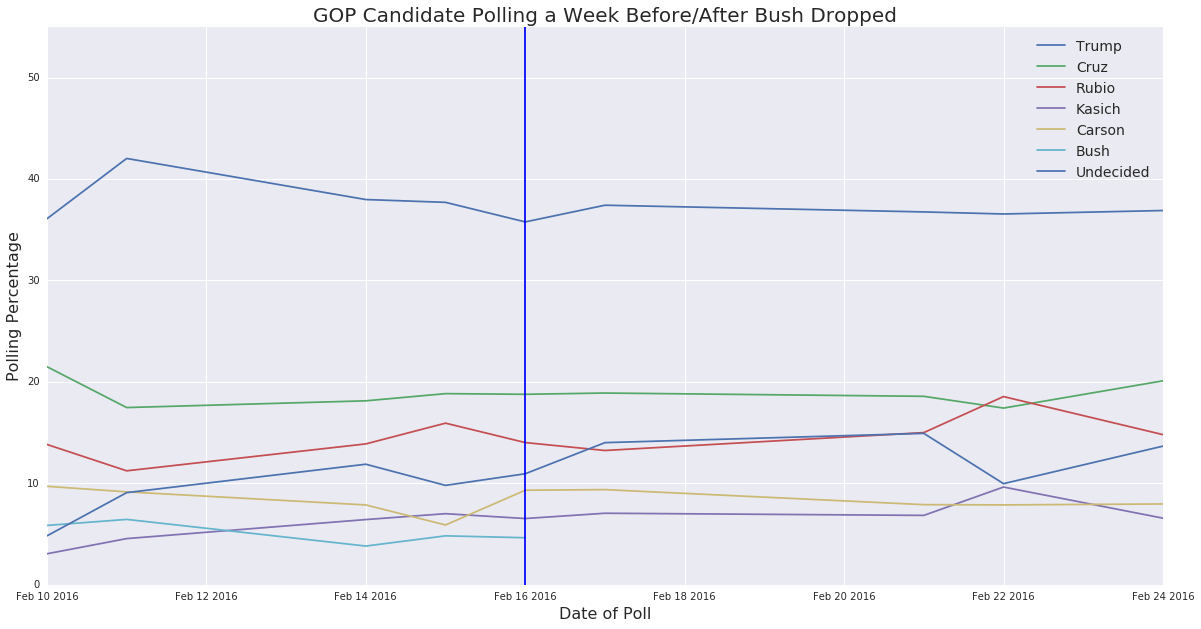

In [24]:
plt.figure(figsize=(20,10))

plt.plot(BushPolls1.Trump)
plt.plot(BushPolls1.Cruz)
plt.plot(BushPolls1.Rubio)
plt.plot(BushPolls1.Kasich)
plt.plot(BushPolls1.Carson)
plt.plot(BushPolls1.Bush)
plt.plot(BushPolls1.Undecided)

plt.axvline(candidates['date']['Bush'])

plt.title("GOP Candidate Polling a Week Before/After Bush Dropped", size=20)
plt.xlabel("Date of Poll", size=16)
plt.ylabel("Polling Percentage", size=16)

# y limits are a little greater than needed to display the legend without blocking out data
plt.ylim(0, 55)
plt.legend(fontsize=14)

## Write to File
Write the DataFrames PollingBeforeDrop and PollingAfterDrop to two separte files to be analyzed in 05-Analysis.ipynb

In [25]:
PollingBeforeDrop.to_csv('PollingBeforeDrop.csv')
PollingAfterDrop.to_csv('PollingAfterDrop.csv')